# Análisis Cosmológico

###  Renée Hložek y Jeff McMahon. Traducción por Cristian Vargas

Vamos a hacer un ejemplo muy aproximado de un MCMC, usando el algoritmo <a href=" https://es.wikipedia.org/wiki/Algoritmo_de_Metropolis-Hastings"> Metroplis Hastings. </a>


Usaremos CAMB python, este se puede obtener de https://pypi.python.org/pypi/camb/0.1.1.

In [1]:
# Importando CAMB
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
print('Usando CAMB instalado en '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower

Usando CAMB instalado en /Users/cvargas


In [2]:
# Comenzaremos inicializando la estructura de parámetros de CAMB que usaremos más adelante.
# Esto es similar a cambiar el archivo params.ini

#Configurar un nuevo conjunto de parámetros para CAMB
pars = camb.CAMBparams()

#Establecemos el modelo base de cosmología con los siguientes parámetros (los demás se establecen
#en sus valores predeterminados)
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

#El espectro de potencia inicial se establece aquí, por separado del resto de la cosmología.
pars.InitPower.set_params(ns=0.965, r=0)

#Establecemos qué tan lejos en el multipolo queremos los espectros de potencia y activamos
#los valores predeterminados para los parámetros.
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calcular los resultados para estos parámetros
#esto es como "ejecutar" camb desde la línea de comando, y es lo mismo que se hace en cosmomc
results = camb.get_results(pars)

#obtener diccionario de espectros de potencia CAMB
powers =results.get_cmb_power_spectra(pars)

In [3]:
# Veamos cuáles son los espectros de potencia:
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [4]:
# total           : espectro total, suma de todas las componentes
# unlensed_scalar : espectro escalar sin efecto lente
# unlensed_total  : espectro total sin efecto lente
# lensed_scalar   : espectro escalar con efecto lente
# tensor          : espectro tensorial
# lens_potential  : espectro del potencial del efecto lente

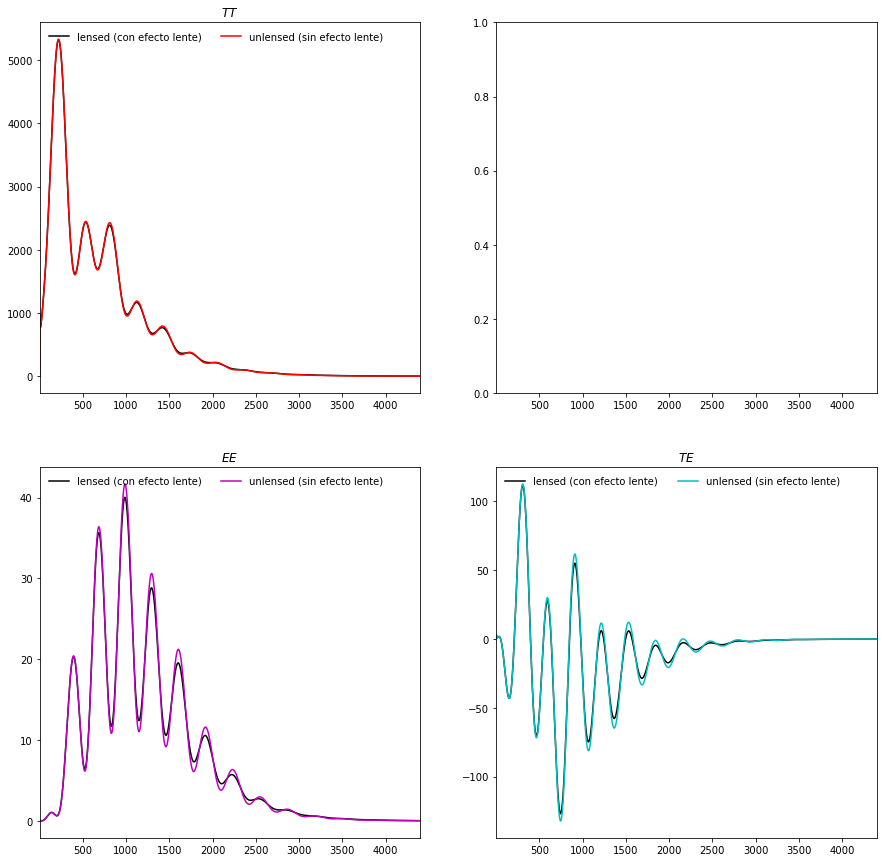

In [5]:
#Ahora graficaremos los espectros de potencia CMB total con y sin efecto lente.

totCL=powers['total']
CMBOutscale = 7.43e12
unlensedCL=powers['unlensed_scalar']

#Los arreglos CL de Python están todos basadas en cero (comenzando en L = 0), 
#tenga en cuenta que las entradas L = 0,1 serán cero de forma predeterminada.

#Los diferentes CL siempre están en el orden TT, EE, BB, TE (con BB=0 para resultados escalares sin lente).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].plot(ls,CMBOutscale*totCL[:,0], color='k', label='lensed (con efecto lente)')
ax[0,0].plot(ls,CMBOutscale*unlensedCL[:,0], color='r', label='unlensed (sin efecto lente)')
ax[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[0,0].set_title(r'$TT$')
ax[1,0].plot(ls,CMBOutscale*totCL[:,1], color='k', label='lensed (con efecto lente)')
ax[1,0].plot(ls,CMBOutscale*unlensedCL[:,1], color='m', label='unlensed (sin efecto lente)')
ax[1,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2,frameon=False)
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,CMBOutscale*totCL[:,3], color='k', label='lensed (con efecto lente)')
ax[1,1].plot(ls,CMBOutscale*unlensedCL[:,3], color='c', label='unlensed (sin efecto lente)')
ax[1,1].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[1,1].set_title(r'$TE$');

for ax in ax.reshape(-1): ax.set_xlim([2,4400])

### Ahora que hemos ejecutado camb una vez y sabemos cómo hacerlo, también podemos calcular Cls sobre un rango de parámetros.

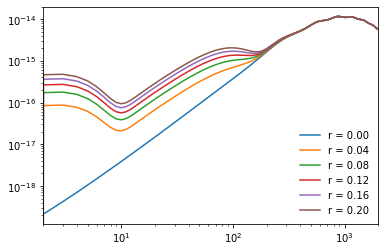

In [6]:
#Puedes calcular espectros para diferentes espectros de potencia primordial sin volver a calcular todo
#por ejemplo, representemos los espectros BB en función de r
pars.WantTensors = True
resultados = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    params_inflacion = initialpower.InitialPowerLaw()
    params_inflacion.set_params(ns=0.96, r=r)
    resultados.power_spectra_from_transfer(params_inflacion)
    cl = resultados.get_total_cls(lmax)
    plt.loglog(np.arange(lmax+1),cl[:,2], label='r = %.2f'%r)
plt.xlim([2,lmax])
plt.legend( loc='lower right', frameon=False);

## Ahora hagamos una probabilidad falsa para los datos CMB S4 TT. TENER EN CUENTA que esto está súper simplificado, en general tenemos una probabilidad mucho más complicada, y cualquier otro espectro estará correlacionado.

In [7]:
## Probabilidad falsa basada en simulaciones de ruido realistas a ell-alto para datos de CMB-S4


def s4_tt_likelihood(modell,loaddata=True):
    if loaddata: 
        # si es que es la primera vez, carga los datos
        data = np.loadtxt('./binned_errors.dat', unpack=True)
    modeltt = np.zeros(len(data[0]))
    inds = (data[0]-0.5)
    inds = inds.astype(int)
    for i,ind in enumerate(inds):
        modeltt[i] = modell[ind]
    
    #plt.figure()
    #plt.plot(data[0],modeltt,color="red")
    #plt.errorbar(data[0], data[1], yerr=data[2],fmt=".")
    #plt.xlim(0.,1500.)
    
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike
    

Lo primero que notamos es que no deberíamos simplemente tomar el espectro del modelo en ese bin, sino que deberíamos binear la teoría

<font color='red'>EJERCICIO: </font> Escriba un módulo para binear la teoría en el mismo rango de ell que los datos bineados.


In [8]:
# Tu código va aquí

Tu discusión va aquí

In [9]:
# Llamemos al módulo para el espectro que tenemos arriba.

model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(cltt)
print(loglike)


-5083.169106614558


### Ahora vamos a llamar a CAMB con un vector param de la misma manera que arriba, y calcularemos la probabilidad logarítmica para esto.

In [10]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
pars = camb.CAMBparams()
pars.set_cosmology(H0=paramsvec[0], ombh2=paramsvec[1], omch2=paramsvec[2], mnu=0.06, omk=paramsvec[3],tau=paramsvec[4])
pars.InitPower.set_params(ns=paramsvec[5], r=0)
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calcular los resultados para estos parámetros
result = camb.get_results(pars)

#obtener diccionario de espectros de potencia CAMB "powers"
powers =result.get_cmb_power_spectra(pars)
totCL=powers['total']
model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(cltt)
print(loglike)

-5083.169106614558


### Queremos dar pasos en este espacio de parámetros 6-D especificado por el vector de pasos.

In [11]:
# Usando este código anterior, podemos tomar un paso gaussiano especificado por el vector de paso a continuación
vector_pasos = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
npasos = 2
loglike = np.zeros(npasos)
for i in range(npasos):
    if i==0:
        # primer paso
        paso = paramsvec
    else:
        # Dar un paso gaussiano desde la posición anterior
        paso = paso+np.random.randn(len(paramsvec))*vector_pasos
    # Inicializar los parámetros en CAMB 
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=paso[0], ombh2=paso[1], omch2=paso[2], mnu=0.06, omk=paso[3], tau=paso[4])
    pars.InitPower.set_params(ns=paso[5], r=0)
    pars.set_for_lmax(4400, lens_potential_accuracy=0)
    # Calcula el espectro
    powers = result.get_cmb_power_spectra(pars)
    totCL = powers['total']
    model = totCL
    cltt = totCL[:,0]*CMBOutscale
    loglike[i] = s4_tt_likelihood(cltt)
print('vector loglike =', loglike)

vector loglike = [-5083.16910661 -5502.08763317]


## MCMC (Markov Chain Monte Carlo/Métodos de Montecarlo basados en cadenas de Markov)
Estamos listos para hacer el MCMC. Definiremos la versión más simple/más fea del algoritmo Metropolis Hastings:

In [12]:
def mcmc_mh(ratln):
    aceptar=False
    r1 = np.random.rand()
    # Si el paso es definitivamente mejor, queremos aceptarlo.
    # Si no es necesariamente mejor, queremos lanzar un número aleatorio y pasar si lo superamos.
    if np.exp(ratln) > r1:
        aceptar=True
    return aceptar

In [13]:
# Usando este código anterior, podemos tomar un paso gaussiano especificado por el vector de paso a continuación
vector_pasos = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])

pasos = 100
loglike = np.zeros(pasos)
pasosmantenidos = np.zeros((pasos,len(paramsvec)+1))
for i in range(pasos):
    
    if i==0:
        paso = paramsvec
        accept=True
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=paso[0], ombh2=paso[1], omch2=paso[2], mnu=0.06, omk=paso[3], tau=paso[4])
        pars.InitPower.set_params(ns=paso[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        loglike[i] = s4_tt_likelihood(cltt)
        #print loglike[i]
        pasosmantenidos[i,0:len(paramsvec)] = paso
        pasosmantenidos[i,len(paramsvec)]= loglike[i]
    else:
        paso = pasosmantenidos[i-1,0:len(paramsvec)]+np.random.randn(len(paramsvec))*vector_pasos
        #print paso
        pars = camb.CAMBparams()
        # Poner el vector param en la estructura camb
        pars.set_cosmology(H0=paso[0], ombh2=paso[1], omch2=paso[2], mnu=0.06, omk=paso[3], tau=paso[4])
        pars.InitPower.set_params(ns=paso[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        # calcular el espectro de potencia
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        # calcular la probabilidad
        loglike[i] = s4_tt_likelihood(cltt)
        rat = loglike[i]-loglike[i-1]
        accept = mcmc_mh(rat)
        
        if accept:   
            pasosmantenidos[i,0:len(paramsvec)] = paso
            pasosmantenidos[i,len(paramsvec)] = loglike[i]
        else:
            pasosmantenidos[i,0:len(paramsvec)] = pasosmantenidos[i-1,0:len(paramsvec)]
            loglike[i] = loglike[i-1]
            pasosmantenidos[i,len(paramsvec)] = loglike[i]
               
np.savetxt('cadena.txt', pasosmantenidos, delimiter=' ', fmt='%.3e')
print('Estamos listos')

/var/folders/x6/1c1sz3rn4kj8kvd0rzmjjbcm0000gn/T/ipykernel_8785/1035911016.py:6: RuntimeWarning: overflow encountered in exp
  if np.exp(ratln) > r1:


Estamos listos


### En realidad, no queremos leer los datos cada vez.
<font color='red'>EJERCICIO: </font> Cambie la función de probabilidad para que solo lea los datos la primera vez que se llama.

In [14]:
## Tu código va aquí

Tus notas van aquí

(7, 100)


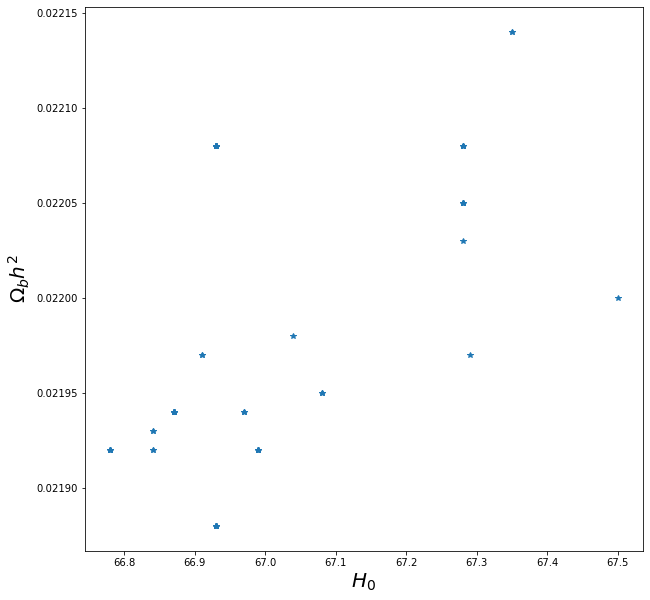

In [15]:
# Leer la cadena
cadena = np.loadtxt('cadena.txt', unpack=True)
print(np.shape(cadena))
plt.figure(figsize=(10,10))
plt.plot(cadena[0,:], cadena[1,:], marker='*', linestyle='None')
plt.xlabel(r'$H_0$', fontsize=20)
plt.ylabel(r'$\Omega_bh^2$', fontsize=20)
plt.show()

### ¡Este código es realmente feo (y lento)!
<font color='red'>EJERCICIO: </font>  Escriba funciones/módulos que aceleren el código MCMC anterior.

In [16]:
## Tu código va aquí

Tu discusión va aquí.

### Ahora queremos comprobar la relación de aceptación/rechazo de las cadenas. En general queremos que esté entre 0.2-0.4. Para cambiar esto, cambia el tamaño de los pasos en la dirección de cada parámetro.

<font color='red'>EJERCICIO: </font> Modifica tu código anterior de forma que calcule la relación de aceptación/rechazo mientras se realizan los pasos.

In [17]:
## Tu código va aquí

Tu discusión va aquí.

### En general, ayuda estar en a) una buena parte del espacio de parámetros cuando se comienza y b) no usar una matriz de pasos diagonales, sino usar la correlación entre parámetros.

<font color='red'>EJERCICIO: </font> Modifica tu función escalonada para crear una matriz de covarianza (determinada a partir de un recorrido más corto de la cadena) y da pasos usando esta matriz de covarianza.

In [18]:
## Tu código va aquí

Tu discusión va aquí.